### **Imports and utils**

Importing libraies

In [6]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import Accuracy
#from sklearn.model_selection import train_test_split

Utils functions

In [7]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='gist_gray'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = []
    list_arrays_normalized += [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

### **Denoising**

Opening denoising data

In [4]:
image_file_path = 'outputs/output_denoising_snr100.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

ResUNet

In [27]:
# from paper Qian, H. et al 2022

def resnet_block(x, x_shortcut, num_filters, kernel_size=3):
    # Main block
    rb = Conv2D(num_filters, kernel_size, padding='same')(x)
    rb = BatchNormalization()(rb)
    rb = Activation('relu')(rb)
    rb = Conv2D(num_filters, kernel_size, padding='same')(rb)

    # Add
    x_shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(x_shortcut)
    #x_shortcut = BatchNormalization()(x_shortcut)
    rb = Add()([x_shortcut, rb])

    return rb

def upsample_concatenate(x, skip):
    x = UpSampling2D((2, 2))(x)

    return Concatenate()([x, skip])

def resUnet(input_shape=(48, 48, 1), num_filters=64, num_resnetblocks=4, kernel_size=3): # change filters dynamically and check blocks
    inputs = Input(input_shape)

    # Encoder
    x = inputs
    skip_connections = []
    for i in range(num_resnetblocks):
        if not i == 0: x = BatchNormalization()(x)
        x = resnet_block(x, x, num_filters, kernel_size)
        if not i == num_resnetblocks-1:
            skip_connections += [x] # copy maybe
            x = Conv2D(num_filters, kernel_size, strides=2, padding='same')(x)

    # Transition
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)

    # Decoder
    for skip in reversed(skip_connections):
        x = upsample_concatenate(x, skip)
        x_shortcut = x
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = resnet_block(x, x_shortcut, num_filters, kernel_size)

    x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    network = Model(inputs, outputs)

    return network

Training ResUnet

In [ ]:
#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Spliting training and testing
train = img_data[0:train_idx]
train_x = train[[i for i in range(0, len(train), 2)]]
train_y = train[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
test_x = test[[i for i in range(0, len(test), 2)]]
test_y = test[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(test_x[idx])
show_image(test_y[idx])

In [28]:
resunet_model = resUnet(input_shape=img_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)
resunet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 64)           0         ['batch_normalization[0][0

In [ ]:
resunet_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

batch_size = 128
epochs = 25
history = resunet_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_y))

In [ ]:
predictions = resunet_model.predict(test_x)
idx = 0
show_image(test_x[idx])
show_image(predictions[idx])

Saving model to file

In [ ]:
resunet_model.save('resunet_100snr2.keras')

**Deconvolution**

Importing images and spliting training and testing datasets

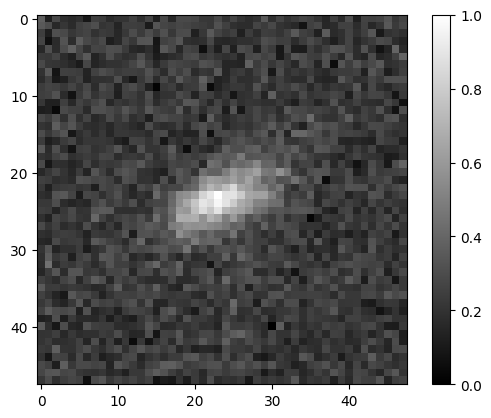

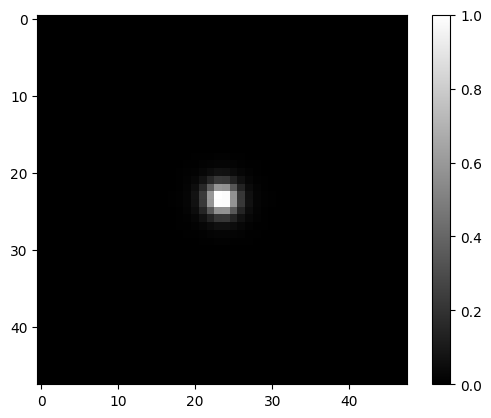

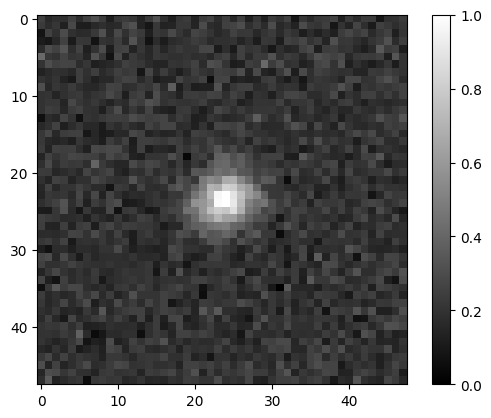

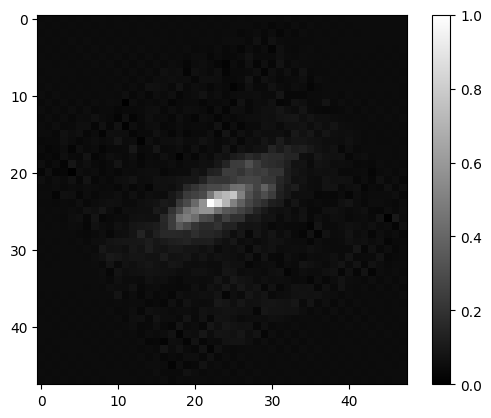

In [30]:
# Importing images
image_file_path = 'outputs/output_deconv_snr100_5k.fits'
img_head, img_data = read_header_and_data(image_file_path, 0) # img_data = [mod_img1, original_img1, mod_img2, original_img2, ...]

image_psf_file_path = 'outputs/output_deconv_snr100_5k_psf.fits'
psf_head, psf_data = read_header_and_data(image_psf_file_path, 0)

# Normalizing images
img_data = normalize_list(img_data)
psf_data = normalize_list(psf_data)

# Reshaping images
img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
psf_data = np.array([np.reshape(psf, (img_size, img_size, 1)) for psf in psf_data])
img_shape = img_data[0].shape

# Spliting training and testing
train_split = 0.7
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_idx = int(num_total * train_split)

img_train = img_data[0:train_idx]
psf_train = psf_data[0:train_idx]

img_test = img_data[train_idx:num_total] # It is only necessary to get the images test, not the psf

# Image train
img_train_x = img_train[[i for i in range(0, len(img_train), 2)]]
img_train_y = img_train[[i for i in range(1, len(img_train), 2)]]

# PSF of the train images
psf_train_x = psf_train[[i for i in range(0, len(psf_train), 2)]]

img_test_x = img_test[[i for i in range(0, len(img_test), 2)]]
img_test_y = img_test[[i for i in range(1, len(img_test), 2)]]

idx = 0
show_image(img_train_x[idx])
show_image(psf_train_x[idx])
show_image(img_test_x[idx])
show_image(img_train_y[idx])

Unrolled ADMM Network

In [41]:
def compute_alpha(N, y, beta=0.33):
    return np.sum(y) / (N*beta)

def unrolled_admm_model(input_shape, n):
    # Inputs
    y = Input(shape=input_shape)
    h = Input(shape=input_shape)
    
    # Initializing parameters
    N = input_shape[0]
    alpha = compute_alpha(N, y) # 500, 200
    alpha_inv = 1 / alpha

    # Initialize x with Wiener Filter
    Y = np.fft.fft(y)
    H = np.fft.fft(h)
    Ht = H.T
    Ht_conj = Ht.conj()
    x = [alpha_inv * np.fft.ifft((Ht_conj * Y) / (alpha_inv + abs(H)**2))]

    # Initialize other parameters
    z = [x[0]]
    v = [y]
    u1 = [0]
    u2 = [0]

    # Hyperparameters (can be initialized by nn)
    rho1 = 10e3 # rho1 in (10−5, 10−2)
    rho2 = 10e3 # rho2 in ?
    gamma = 1.5 # gamma in (1, 2)

    # ADMM iterations
    for k in range(1, n):
        x[1] = np.fft.ifft()


alpha = 500
alpha_inv = 1 / alpha
y = img_train_x[0]
h = psf_train_x[0]
Y = np.fft.fft(y)
H = np.fft.fft(h)
Ht = H.T
Ht_conj = Ht.conj()
x = [alpha_inv * np.fft.ifft((Ht_conj * Y) / (alpha_inv + abs(H)**2))]
